In [1]:
!pip install numpy pandas scikit-learn wandb


  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached wandb-0.19.7-py3-none-macosx_11_0_arm64.whl.metadata (10 kB)
  Using cached scipy-1.15.2-cp312-cp312-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached GitPython-3.1.44-py3-none-any.whl.metadata (13 kB)
  Using cached platformdirs-4.3.6-py3-none-any.whl.metadata (11 kB)
  Using cached psutil-7.0.0-cp36-abi3-macosx_11_0_arm64.whl.metadata (22 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached sentry_sdk-2.22.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached setproctitle-1.3.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (10 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached annotated_types-0.7.0-py3-

In [2]:
import wandb
wandb.login(key="569c283675332b36510cbe02fa957b4e84eec832")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/harkiratsingh/.netrc
wandb: Currently logged in as: harkiratsingh24022004 (harkiratsingh24022004-plaksha-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

#### Instructions
###### Follow the instructions given in comments prefixed with ## and write your code below that.
###### Also fill the partial code in given blanks. 
###### Don't make any changes to the rest part of the codes

### Answer the questions given at the end of this notebook within your report.


### You would need to submit your GitHub repository link. Refer to the Section 6: Final Submission on the PDF document for the details.


In [3]:
## import cv2
import cv2
## import numpy
import numpy as np
## import matplotlib pyplot
import matplotlib.pyplot as plt
## import KMeans cluster from sklearn
from sklearn.cluster import KMeans
## import distance from scipy.spatial
from scipy.spatial import distance

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.metrics import accuracy_score, log_loss, silhouette_score, confusion_matrix

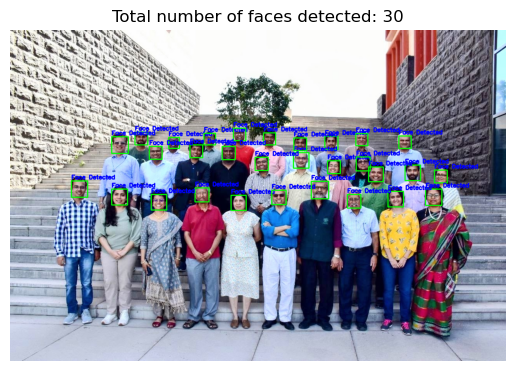

In [4]:
# Read the image
img = cv2.imread('Plaksha Faculty.jpg')

# Check if the image is loaded successfully
if img is None:
    raise ValueError("Error: Image not found. Check the file path.")

# Convert to RGB and grayscale
rgb_pf = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(rgb_pf, cv2.COLOR_RGB2GRAY)

# Load Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Detect faces with adjusted parameters
faces_rect = face_cascade.detectMultiScale(gray_img, scaleFactor=1.05, minNeighbors=4, minSize=(25, 25), maxSize=(50, 50))

# Define text and font parameters
text = "Face Detected"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_color = (0, 0, 255)  # Red in BGR
font_thickness = 2

# Draw rectangles and labels around detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(rgb_pf, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle
    cv2.putText(rgb_pf, text, (x, y - 5), font, font_scale, font_color, font_thickness)

# Display image with title
plt.imshow(rgb_pf)
plt.title(f"Total number of faces detected: {len(faces_rect)}")
plt.axis("off")

# Save the output image
plt.savefig("detected_faces_img.png")
plt.show()


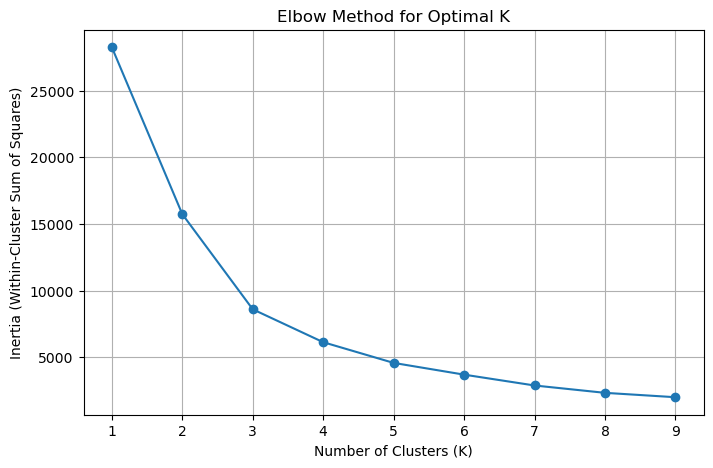

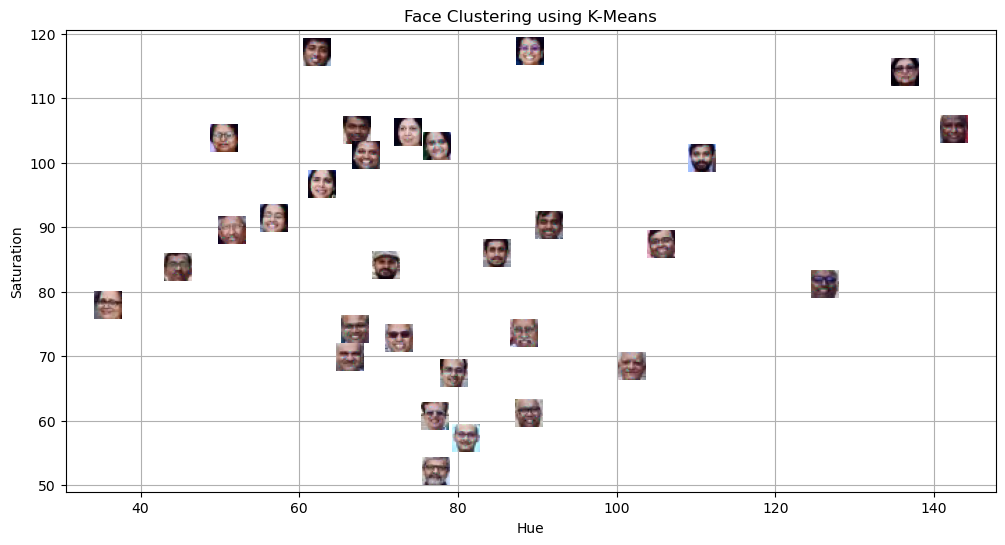

In [11]:
# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # Convert image from BGR to HSV
hue_saturation = []
face_images = []  # Store detected face images

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

# Initialize Weights & Biases (wandb)
wandb.init(project="distance_classification_project", name="KMeans_Clustering")

# Perform K-Means Clustering: Use Elbow Method to Determine Optimal k
inertia_values = []
K_range = range(1, 10)  # Try k values from 1 to 9

for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=40).fit(hue_saturation)
    inertia_values.append(kmeans_test.inertia_)

# Plot Elbow Method 
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_values, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.savefig("Elbow Plot.png")
plt.show()  

optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=45, n_init=40).fit(hue_saturation)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x, y, w, h) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'bo')

# Labels and title
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Face Clustering using K-Means")
plt.grid()
plt.show()  


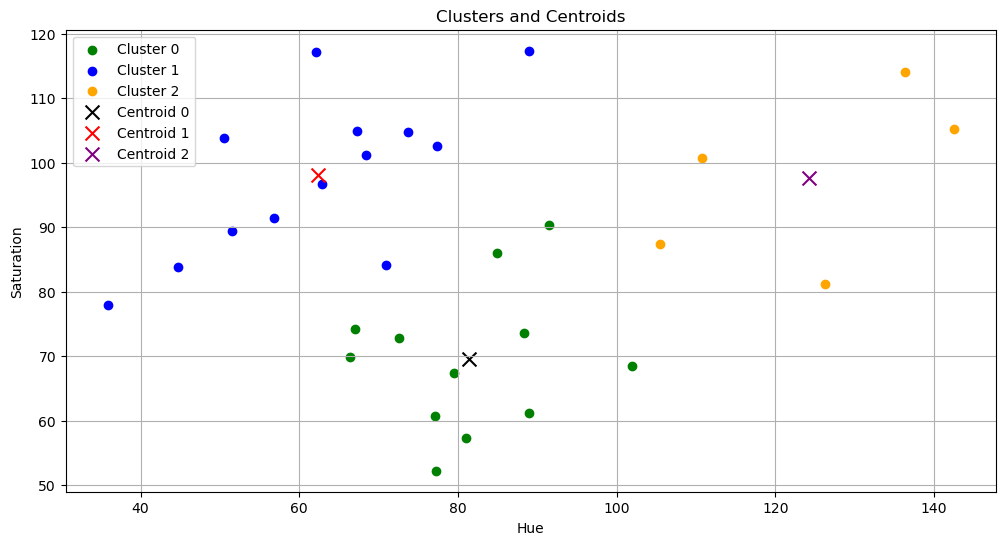

In [6]:
# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []
cluster_2_points = []  

# Scatter plot loop
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    elif kmeans.labels_[i] == 1:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_2_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))  # Assign third cluster

# Convert lists to numpy arrays
cluster_0_points = np.array(cluster_0_points)
cluster_1_points = np.array(cluster_1_points)
cluster_2_points = np.array(cluster_2_points)  # Convert third cluster

# Plot clusters
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label='Cluster 0')
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label='Cluster 1')
plt.scatter(cluster_2_points[:, 0], cluster_2_points[:, 1], color='orange', label='Cluster 2')  # Third cluster

# Calculate and plot centroids
centroid_0 = kmeans.cluster_centers_[0]
centroid_1 = kmeans.cluster_centers_[1]
centroid_2 = kmeans.cluster_centers_[2]  # Third cluster centroid

plt.scatter(centroid_0[0], centroid_0[1], color='black', marker='x', s=100, label='Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], color='red', marker='x', s=100, label='Centroid 1')
plt.scatter(centroid_2[0], centroid_2[1], color='purple', marker='x', s=100, label='Centroid 2')  # Third cluster centroid

# Labels, title, legend, and grid remain unchanged
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Clusters and Centroids")
plt.legend()
plt.grid()

# Save and log image
plt.savefig("clusters_and_centroids.png")
wandb.log({"Cluster Visualization": wandb.Image("clusters_and_centroids.png")})
plt.show()


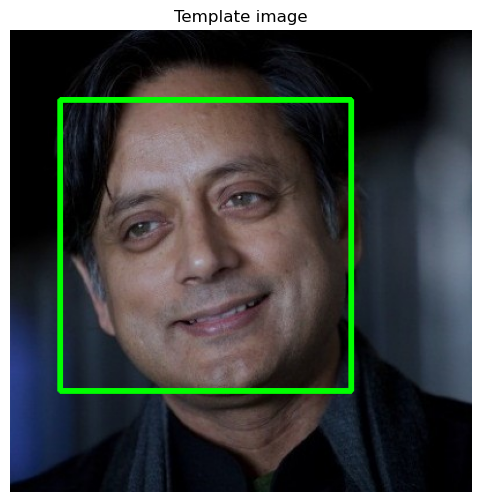

In [7]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img = cv2.imread('Dr_Shashi_Tharoor.jpg')
# Detect face  in the template image after converting it to gray and store it in template_faces
rgb_temp = cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB)
gray_temp = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)

template_faces = face_cascade.detectMultiScale(gray_temp, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(rgb_temp, (x, y), (x + w, y + h), (0, 255, 0), 3)
plt.figure(figsize = (8, 6))
plt.imshow(rgb_temp)
plt.title("Template image")
plt.axis("off")
plt.savefig("template image.png")
plt.show()    

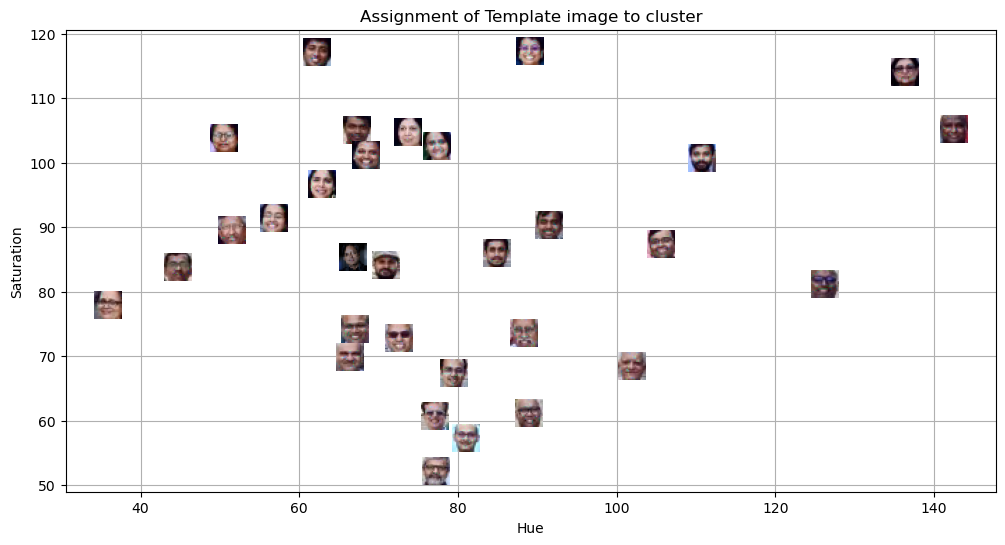

In [8]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])

# Predict the cluster label for the template image and store it in template_label
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

## Put x label
plt.xlabel("Hue")
## Put y label
plt.ylabel("Saturation")
## Put title
plt.title("Assignment of Template image to cluster")
## Add grid
plt.grid()
## show plot
plt.savefig("Assignment of Template image to cluster.png")
plt.show()

The template image belongs to: Cluster 1


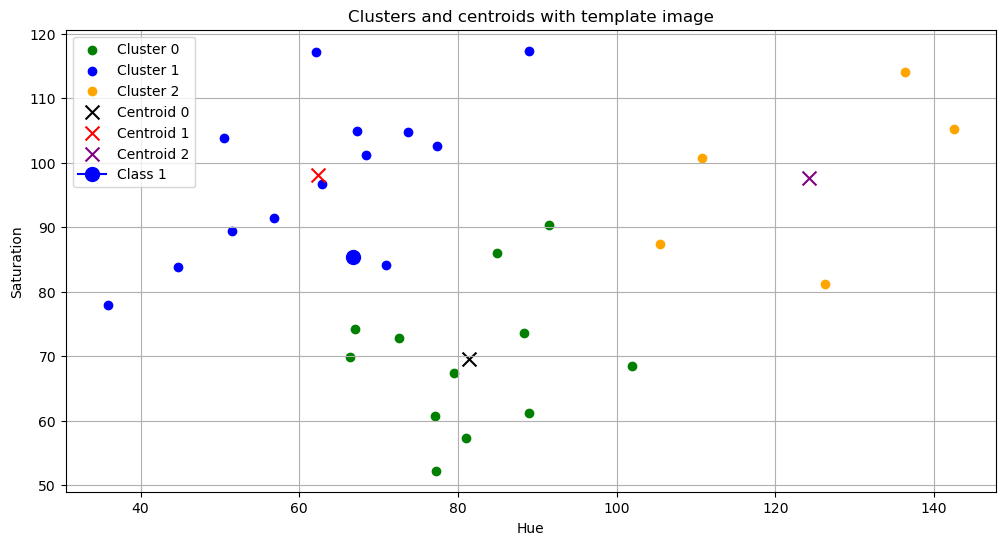

In [12]:
import numpy as np

# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []
cluster_2_points = []  # Added for third cluster

# Scatter plot setup
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    elif kmeans.labels_[i] == 1:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_2_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))  # Assign third cluster

# Convert lists to numpy arrays
cluster_0_points = np.array(cluster_0_points)
cluster_1_points = np.array(cluster_1_points)
cluster_2_points = np.array(cluster_2_points)

# Plot clusters
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label='Cluster 0')
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label='Cluster 1')
plt.scatter(cluster_2_points[:, 0], cluster_2_points[:, 1], color='orange', label='Cluster 2')  # Third cluster

# Calculate and plot centroids
centroid_0 = kmeans.cluster_centers_[0]
centroid_1 = kmeans.cluster_centers_[1]
centroid_2 = kmeans.cluster_centers_[2]

plt.scatter(centroid_0[0], centroid_0[1], color='black', marker='x', s=100, label='Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], color='red', marker='x', s=100, label='Centroid 1')
plt.scatter(centroid_2[0], centroid_2[1], color='purple', marker='x', s=100, label='Centroid 2')

# Function to compute Euclidean distance
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Convert template point to array
template_point = np.array([template_hue, template_saturation])

# Compute distances from template point to each centroid
distances = [
    euclidean_distance(template_point, centroid_0),
    euclidean_distance(template_point, centroid_1),
    euclidean_distance(template_point, centroid_2)
]

# Get the closest cluster index
closest_cluster = np.argmin(distances)

# Define cluster colors for visualization
cluster_colors = ['green', 'blue', 'orange']
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# Plot the template image point with the closest cluster color
plt.plot(template_hue, template_saturation, marker='o', 
         c=cluster_colors[closest_cluster], markersize=10, label=f'Class {closest_cluster}')

# Print the assigned class
print(f"The template image belongs to: {cluster_names[closest_cluster]}")

# Labels and title
plt.xlabel("Hue")
plt.ylabel("Saturation")
plt.title("Clusters and centroids with template image")

# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.savefig("Added Template Image to Cluster.png")
plt.show()


## Report:
## Answer the following questions within your report:


#### 1. What are the standard distance metrics used for distance-based classification algorithms? 

* Euclidean Distance: Used for calculating the distance between two points in space.
* Manhattan Distance: Calculates how many horizontal and vertical steps there are from starting point to ending point, similar to navigating in a city block.
* Mahalanobis Distance: The correlations between variables are considered and thus, the distance relative to the data distribution is calculated.
* Minkowski Distance: This is a general case that Euclidean distance and Manhattan distance are special cases of.
* Cosine Similarity: Calculates the distance by calculating angles between vectors and is often used when direction matters more than magnitude.
* Hamming Distance: Measures the number of differences between two vectors of the same length.

#### 2. What are some applications in real life for distance-based classification algorithms?

* Recommender Systems: Suggests products, films, or songs based on similarity to past interest.
* Medical Diagnosis: Tags diseases based on similarity to known cases with comparable symptoms.
* Anomaly Detection: Identifies strange transactions based on how similar to normal transactions they are.
* Image Recognition: Compares facial features in a picture against the faces of known individuals.

#### 3. Explain some various distance metrics.

* Euclidean Distance:
It estimates the straight-line distance between two points.
Performs well when all the features are of equal importance and there are no correlations among them and is used often in clustering and nearest neighbor techniques.

* Manhattan Distance:
Computes distance along horizontal and vertical displacements, similar to moving around a city grid.This distance metric is helpful when movement is limited to a few directions (e.g., in grid-based maps).

* Mahalanobis Distance:
Accounts for correlations between variables and normalizes the distances accordingly.
Comes in handy when data points vary in variances or are dispersed in different directions.It is commonly applied in anomaly detection and classification.

#### 4. How is model performance improved through cross validation?
Cross-validation is used to verify how accurately a model will perform on unknown data by dividing the dataset into various parts.

* Prevents Overfitting: Makes the model not learn the training set.
* Improves Generalization: Helps validate how the model will perform on real data.
* Hyperparameter Tuning: Finds the best values, i.e., the best number of neighbors in KNN.

#### 5. Define variance and bias in the case of KNN?
* Bias: This occurs when the model makes a strong assumption and, therefore, simplifies too much and has low accuracy. There is high bias when there are numerous neighbors in KNN because the model smooths away differences too much.
* Variance: When the model is oversensitive to little fluctuations in data, thus resulting in inconsistency in predictions. It produces high variance with very few neighbors in KNN since the model overreacts on individual points.